# Diet and Health
Updated April 21, 2017

Stephen Klosterman, steve.klosterman@gmail.com

People say "you are what you eat."  In this notebook, I examine how conventional wisdom stands up to data:  does our diet determine our health outcomes?  To characterize world diets, I use data on consumption of over 100 food items on a per country basis, from the United Nations Food and Agriculture Organization (FAO).  For health outcomes, I use non-communicable disease data from the World Health Organization (WHO).  After exploring and cleaning the data, I use statistical methods to examine whether world diets can explain variation in mortality rates across countries, and which food items are linked to disease.

This notebook is a work in progress and will be updated.  Currently there is:

1. Exploratory data analysis
 - Mapping
 - Cleaning
 - Database merging
2. Data analysis
 - Linear and lasso regression

Coming soon:  principal component analysis

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import itertools
%matplotlib inline

# Cardiovascular disease data
This data comes from the WHO database (http://www.who.int/gho/database/en/).  Cardiovascular disease is an example of a non-communicable disease, meaning it is not contagious, although genetic factors may be involved.  Lifestyle choices such as diet and exercise are thought to be important factors in whether someone develops cardiovascular disease.  I examine diet in this notebook.

Here I load the disease data and separate the WHO 2000 survey as training data and 2012 as testing data.  I will train a regression model using food consumption from the 11 years preceding 2000 as predictors, and test it using similar data for 2012.

In [2]:
#Load cardiovascular disease data
cardio_file = '../data/data.csv'
cardio_data = pd.read_csv(cardio_file)

#Select relevant field
cardio_data_all = cardio_data.drop(['Age-standardized mortality rate by cause (per 100 000 population).1', \
                  'Age-standardized mortality rate by cause (per 100 000 population).2'], axis=1)

cardio_years = ['2000', '2012']
cardio_data = []
#Create list of dataframes in 'cardio_data' according to 'cardio_years'
for i in np.arange(len(cardio_years)):
    #Isolate data from year of interest
    cardio_data.append(cardio_data_all[cardio_data_all['Unnamed: 1'].isin([cardio_years[i]])])
    #Drop year column
    cardio_data[i] = cardio_data[i].drop(['Unnamed: 1'], axis=1)
    #Rename country column
    cardio_data[i] = cardio_data[i].rename(columns={'Unnamed: 0' : 'Country'})
    
# Set disease dataframe indices as country to prepare for merging
cardio_data[0] = cardio_data[0].set_index(['Country'])
cardio_data[1] = cardio_data[1].set_index(['Country'])

#Show 2012 data
cardio_data[1].head()

,Age-standardized mortality rate by cause (per 100 000 population)
Country,
Afghanistan,511.5
Albania,436.2
Algeria,396.6
Angola,374.6
Argentina,191.7


## Mapping
Here I create a generic mapping function that will draw a world map of a quantity that varies by country, then use the function to visualize the cardiovascular disease data.

In [13]:
#Mapping function 'map_quantity'
#Inputs
#country_vector:  List of country names (strings)
#quantity_vector:  Corresponding numerical array of quantities
#title:  Title for colorbar
def map_quantity(country_vector, quantity_vector, title):
    #Lists of uncommon country names and their replacements
    map_names_need_changed = [
    'Bolivia',
    "C�te d'Ivoire",
    'Republic of Congo',
    'United Kingdom',
    'The Gambia',
    'Iran',
    'Lao PDR',
    'Macedonia',
    'Dem. Rep. Korea',
    'Syria',
    'Tanzania',
    'United States',
    'Venezuela',
    'Vietnam']
    countries_to_replace = [
    'Bolivia (Plurinational State of)',
    "Cote d'Ivoire",
    'Democratic Republic of the Congo',
    'United Kingdom of Great Britain and Northern Ireland',
    'Gambia',
    'Iran (Islamic Republic of)',
    "Lao People's Democratic Republic",
    'The former Yugoslav republic of Macedonia',
    "Democratic People's Republic of Korea",
    'Syrian Arab Republic',
    'United Republic of Tanzania',
    'United States of America',
    'Venezuela (Bolivarian Republic of)',
    'Viet Nam']

    #Basic stats on data
    min_quant = min(quantity_vector)
    max_quant = max(quantity_vector)
    #Set up map elements and axes
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m',
                                            category='cultural', name=shapename)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_axes([0.05, 0.15, 0.9, 0.8], projection=ccrs.Robinson())
    ax2 = fig.add_axes([0.05, 0.05, 0.9, 0.07])
    #Loop through countries in map database
    for country in shpreader.Reader(countries_shp).records():
        this_country_name = country.attributes['name_long']
        #Change name if necessary
        if this_country_name in map_names_need_changed:
                this_country_name = countries_to_replace[map_names_need_changed.index(this_country_name)]
        #If map country is in list of quantities, assign color based on quantity and map it
        if this_country_name in country_vector:
            #Get quantity for this country
            this_quantity = quantity_vector[country_vector.index(this_country_name)]
            #Scale quantity on [0, 1]
            scaled_quant = (this_quantity - min_quant)/(max_quant - min_quant)
            #Get scaled color for map
            this_color = plt.cm.jet(int(round(scaled_quant*256.)))
            #Plot country with this color
            ax1.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=this_color)
        else:
            #Plot country in gray
            ax1.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=np.array([(0.5, 0.5, 0.5)]))
            #And print the country to know missing countries
            #print this_country_name

    #Create plot
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=min_quant, vmax=max_quant)
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    font_size = 18
    cb.set_label(title,size=18)
    cb.ax.tick_params(labelsize=font_size)
    plt.show()
    return None

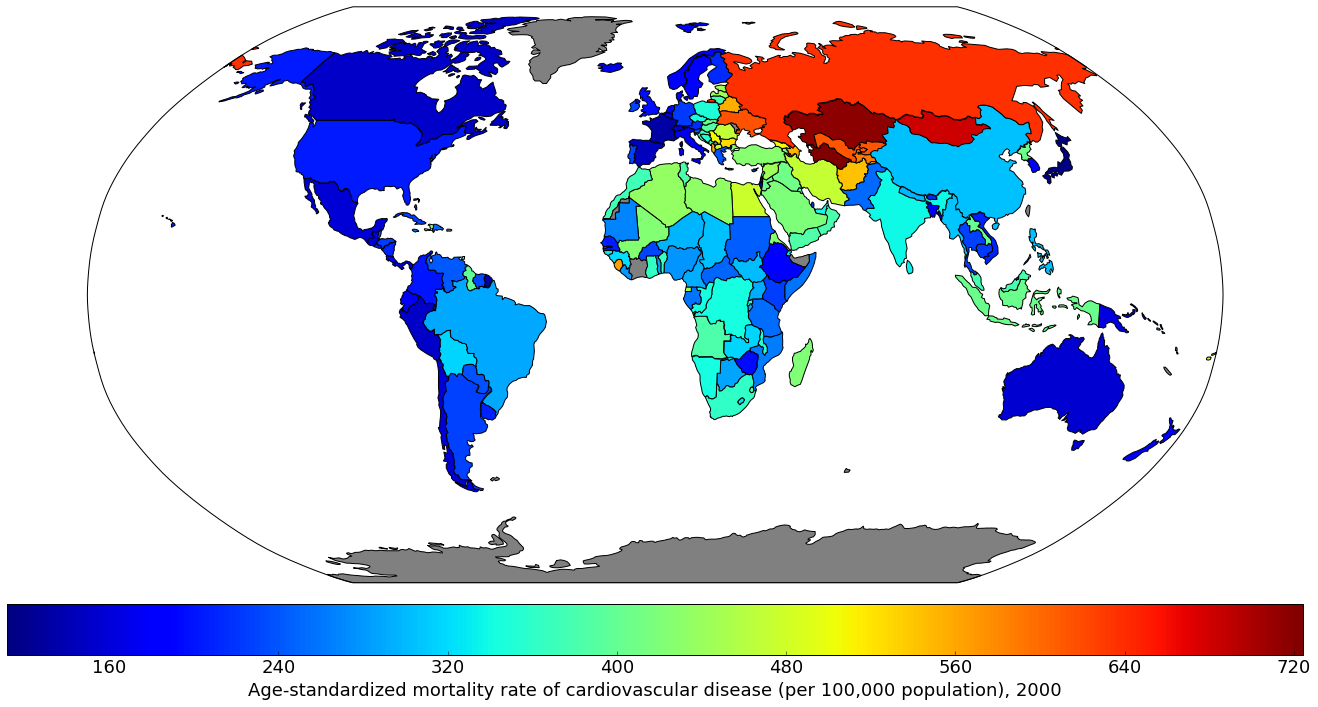

In [14]:
#Select 0 for 2000 results, 1 for 2012
map_index = 0

country_names = cardio_data[map_index].index.values.tolist()

quantity_to_map = cardio_data[map_index]\
['Age-standardized mortality rate by cause (per 100 000 population)'].values.astype('float')

map_title = 'Age-standardized mortality rate of cardiovascular disease (per 100,000 population), '\
+ cardio_years[map_index]
    
map_quantity(country_names, quantity_to_map, map_title)

Northern Central Asia, Russia, and parts of Eastern Europe seem to have the highest incidences.  The Middle East and much of Africa have moderately high but variable rates, while Western Europe, the Americas, Australia, and Eastern Asian countries have relatively low rates of cardiovascular disease.

# Crop data
Data on food consumption is available from the United Nations FAO (http://www.fao.org/faostat/en/#home).  Non-animal products, here called crops, are available separately from animal products.  I load the data, perform some cleaning, and create a subset from the 11 years prior to and including 2000, the year in which I have disease data for model training.  I take a similar approach for testing data, modeling 2012 disease data using food consumption data from 2002-2012.

Using these food consumption data to predict disease represents an assumption that a country's disease mortality rate in a given year is due to the national diet over the preceding 11 years.

First I load the raw data and examine it:

In [15]:
crop_file = '../data/1caaffac-d01c-4d02-8735-404d3089b47e.csv'
crop_data = pd.read_csv(crop_file)

In [16]:
crop_data.head()

,﻿Domain Code,Domain,AreaCode,AreaName,ElementCode,ElementName,ItemCode,ItemName,Year,Value,Flag,FlagD
0,CC,Food Supply - Crops Primary Equivalent,1,Armenia,511,Total Population - Both sexes,2501,Population,1992,3449,NaN,Official data
1,CC,Food Supply - Crops Primary Equivalent,1,Armenia,511,Total Population - Both sexes,2501,Population,1993,3370,NaN,Official data
2,CC,Food Supply - Crops Primary Equivalent,1,Armenia,511,Total Population - Both sexes,2501,Population,1994,3290,NaN,Official data
3,CC,Food Supply - Crops Primary Equivalent,1,Armenia,511,Total Population - Both sexes,2501,Population,1995,3223,NaN,Official data
4,CC,Food Supply - Crops Primary Equivalent,1,Armenia,511,Total Population - Both sexes,2501,Population,1996,3173,NaN,Official data


Here I get a list of the unique crop food items and separate data into training and testing sets.

Notice that some crop items are aggregates of others.  For example, 'Fruits - Excluding Wine' is made up of other food items present in the list.  In terms of the analysis methods used below, this would constitute multicollinearity of predictors, violating the assumptions of linear regression.  Variable selection methods such as lasso would likely remove such correlated predictors, however I remove these manually as this is tractable here.

I take note of these here for later use, guided by the documentation for this data set (FOOD BALANCE SHEETS - A handbook, http://www.fao.org/docrep/003/X9892E/X9892E00.HTM):  'Cereals - Excluding Beer', 'Oilcrops', 'Roots & Tuber Dry Equiv', 'Starchy Roots', 'Sugar & Sweeteners', 'Vegetables', 'Pulses', 'Nuts and products', 'Groundnuts (in Shell Eq)', 'Fruits - Excluding Wine',  'Stimulants', 'Spices', 'Vegetable Oils',  'Alcoholic Beverages', 'Sugar (Raw Equivalent)', 'Sugar, Raw Equivalent', 'Rice (Paddy Equivalent)'.

In [26]:
#Get food item names
#ItemNames
crop_items = crop_data.ItemName.unique()
#Get rid "nan" (last column), but save country populations (first column) for later.  The rest are food items
crop_items = crop_items[0:-1]
#Get rid of Grand Total
crop_items = crop_items[np.not_equal(crop_items, 'Grand Total')]
print crop_items

#Get "food supply" for the requested range of years.  The FAO calculates food supply as production minus exports
#plus imports, so this is a stand-in for consumption.
combined_mask = []
crop_subset = []
crop_year_range = [[1990, 2000], [2002, 2012]]
for i in np.arange(len(crop_year_range)):
    combined_mask.append( crop_data.ItemName.isin(crop_items) & \
        crop_data.ElementName.isin(['Food supply quantity (kg/capita/yr)', 'Total Population - Both sexes']) & \
        (crop_data.Year <= crop_year_range[i][1]) & \
        (crop_data.Year >= crop_year_range[i][0]) )
    crop_subset.append(crop_data[combined_mask[i]])

# crop_subset[0].head()

['Population' 'Wheat and products' 'Barley and products'
 'Maize and products' 'Rye and products' 'Oats' 'Cereals, Other'
 'Potatoes and products' 'Sugar (Raw Equivalent)' 'Sweeteners, Other'
 'Pulses, Other and products' 'Nuts and products' 'Soyabeans'
 'Groundnuts (Shelled Eq)' 'Coconuts - Incl Copra' 'Sesame seed'
 'Olives (including preserved)' 'Oilcrops, Other' 'Soyabean Oil'
 'Groundnut Oil' 'Sunflowerseed Oil' 'Rape and Mustard Oil'
 'Cottonseed Oil' 'Palmkernel Oil' 'Coconut Oil' 'Sesameseed Oil'
 'Olive Oil' 'Maize Germ Oil' 'Oilcrops Oil, Other' 'Tomatoes and products'
 'Onions' 'Vegetables, Other' 'Oranges, Mandarines'
 'Lemons, Limes and products' 'Grapefruit and products' 'Citrus, Other'
 'Bananas' 'Apples and products' 'Pineapples and products' 'Dates'
 'Grapes and products (excl wine)' 'Fruits, Other' 'Coffee and products'
 'Cocoa Beans and products' 'Tea (including mate)' 'Pepper' 'Pimento'
 'Spices, Other' 'Wine' 'Beer' 'Beverages, Fermented'
 'Beverages, Alcoholic' 'I

# Meat and fish data
I take a similar approach with animal products.

In [18]:
#Load data
meat_fish_file = '../data/c1da0671-f39b-4d39-a421-6a19af9d6cd1.csv'
meat_fish_data = pd.read_csv(meat_fish_file)

In [19]:
#Explore data
meat_fish_data.head()

,IDomain Code,Domain,AreaCode,AreaName,ElementCode,ElementName,ItemCode,ItemName,Year,Value,Flag,FlagD
0,CL,Food Supply - Livestock and Fish Primary Equiv...,1,Armenia,511,Total Population - Both sexes,2501,Population,1992,3449,NaN,Official data
1,CL,Food Supply - Livestock and Fish Primary Equiv...,1,Armenia,511,Total Population - Both sexes,2501,Population,1993,3370,NaN,Official data
2,CL,Food Supply - Livestock and Fish Primary Equiv...,1,Armenia,511,Total Population - Both sexes,2501,Population,1994,3290,NaN,Official data
3,CL,Food Supply - Livestock and Fish Primary Equiv...,1,Armenia,511,Total Population - Both sexes,2501,Population,1995,3223,NaN,Official data
4,CL,Food Supply - Livestock and Fish Primary Equiv...,1,Armenia,511,Total Population - Both sexes,2501,Population,1996,3173,NaN,Official data


The aggregate food items here are:  'Meat', 'Fish, Seafood'

In [20]:
#ItemNames
meat_items = meat_fish_data.ItemName.unique()
#Get rid of "nan"
meat_items = meat_items[1:-1]
#Get rid of Grand Total
meat_items = meat_items[np.not_equal(meat_items, 'Grand Total')]
print meat_items

['Bovine Meat' 'Mutton & Goat Meat' 'Pigmeat' 'Poultry Meat' 'Meat, Other'
 'Offals, Edible' 'Fats, Animals, Raw' 'Milk, Whole' 'Butter, Ghee'
 'Cheese' 'Cream' 'Eggs' 'Honey' 'Freshwater Fish' 'Demersal Fish'
 'Pelagic Fish' 'Marine Fish, Other' 'Crustaceans' 'Cephalopods'
 'Molluscs, Other' 'Aquatic Plants' 'Fish, Body Oil' 'Fish, Liver Oil'
 'Milk - Excluding Butter' 'Meat' 'Offals' 'Animal fats' 'Fish, Seafood'
 'Aquatic Products, Other' 'Animal Products' 'Aquatic Animals, Others'
 'Whey' 'Meat Meal' 'Meat, Aquatic Mammals' 'Hides and skins']


In [21]:
#Create subsets
#Get "food supply" for the requested range of years.  The FAO calculates food supply as production minus exports
#plus imports, so this is a stand-in for consumption.
combined_mask = []
meat_subset = []
for i in np.arange(len(crop_year_range)):
    combined_mask.append( meat_fish_data.ItemName.isin(meat_items) & \
        meat_fish_data.ElementName.isin(['Food supply quantity (kg/capita/yr)']) & \
        (meat_fish_data.Year <= crop_year_range[i][1]) & \
        (meat_fish_data.Year >= crop_year_range[i][0]) )
    meat_subset.append(meat_fish_data[combined_mask[i]])

#Make a list of countries
# meat_countries = meat_subset[0].AreaName.unique()
# print meat_countries

# Combine food and disease data
To create predictor variables relevant to the WHO disease data in 2000 and 2012, I compute the mean annual food consumption over each time period of interest (training and testing) using the Pandas groupby function.  This takes a mean for each country, for each food type.  NaN values are ignored.  Then I further clean the data to get rid of fields I don't need for analysis.

In [27]:
#Initialize list of lists, for both food types (crops and meat), each subset into training and testing data
#[value]*number creates a list of size number and initializes each member with value, in Python
#This will be a list of lists of dataframes:
food_means = [[None]*2 for i in range(2)]
# print food_means

#Calculate food means, dropping NaNs
for i in range(2): #training, then testing data
    food_means[0][i] = crop_subset[i].groupby(['AreaName', 'ItemName'], as_index=False).mean()
    food_means[1][i] = meat_subset[i].groupby(['AreaName', 'ItemName'], as_index=False).mean()

food_means[0][0].head()

,AreaName,ItemName,AreaCode,ElementCode,ItemCode,Year,Value
0,Afghanistan,Alcoholic Beverages,2,645,2924,1995,0.000000
1,Afghanistan,Apples and products,2,645,2617,1995,0.830000
2,Afghanistan,Bananas,2,645,2615,1995,0.106364
3,Afghanistan,Barley and products,2,645,2513,1995,8.318182
4,Afghanistan,Beer,2,645,2656,1995,0.000000


In [28]:
#Initialize list of lists, for both food types (crops and meat) and training and testing data
food_means = [[None]*2 for i in range(2)]
# print food_means

#Calculate food means, dropping NaNs

for i in range(2): #training, then testing data
    food_means[0][i] = crop_subset[i].groupby(['AreaName', 'ItemName'], as_index=False).mean()
    food_means[1][i] = meat_subset[i].groupby(['AreaName', 'ItemName'], as_index=False).mean()
    
#Change country name so it's the same between food and disease data
for i in range(2):
    for j in range(2):
        #Change country names
        mask = food_means[i][j].isin(['United Kingdom'])
        food_means[i][j] = food_means[i][j].where(~mask, other='United Kingdom of Great Britain and Northern Ireland')
        
#Perform additional data cleaning and formatting:  drop unnecessary columns, set country as index
for i in range(2):
    for j in range(2):
        food_means[i][j] = food_means[i][j].drop(['AreaCode', 'ElementCode', 'ItemCode', 'Year'], axis=1)
        food_means[i][j] = food_means[i][j].pivot(index='AreaName', columns='ItemName', values='Value')

#Examine columns of dataframe
# food_means[0][0].columns

I use the Pandas merge function first to combine the meat and crop data into one dataframe for all food, and then to combine the food and disease data.  The final merge is an "inner" merge using the indices of country names from each data frame.  The resulting data frame has the food and disease data for the countries in common between each data set.

I also take this opportunity to create a dataframe that has no aggregate food items, to avoid multicollinearity of predictors.

In [30]:
#Merge meat and crop into one food data set
all_food = [None]*2
all_food_no_agg = [None]*2
for i in range(2):  #Training and testing data
    all_food[i] = pd.merge(food_means[0][i], food_means[1][i], right_index=True, left_index=True)
    all_food_no_agg[i] = all_food[i].drop(['Meat', 'Fish, Seafood',
                                   'Cereals - Excluding Beer', 'Oilcrops', 'Roots & Tuber Dry Equiv',
                                    'Starchy Roots', 'Sugar & Sweeteners', 'Vegetables', 'Pulses',
                                    'Nuts and products', 'Groundnuts (in Shell Eq)', 'Fruits - Excluding Wine',
                                    'Stimulants', 'Spices', 'Vegetable Oils', 'Alcoholic Beverages',
                                    'Sugar (Raw Equivalent)', 'Sugar, Raw Equivalent',
                                    'Rice (Paddy Equivalent)'], axis=1)

#There are a few more countries in 2000 than 2012, same number of food items
print all_food[0].shape, all_food[1].shape
all_food[1].head()
# all_food[1]['Population']



(214, 124) (211, 124)


ItemName,Alcoholic Beverages,Apples and products,Bananas,Barley and products,Beans,Beer,"Beverages, Alcoholic","Beverages, Fermented",Cassava and products,Cereals - Excluding Beer,...,Milk - Excluding Butter,"Milk, Whole","Molluscs, Other",Mutton & Goat Meat,Offals,"Offals, Edible",Pelagic Fish,Pigmeat,Poultry Meat,Whey
AreaName,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.110909,1.463636,0.597273,3.284545,NaN,0.094545,0.005455,NaN,NaN,174.887273,...,63.516364,35.563636,NaN,5.080000,1.877273,1.877273,NaN,NaN,1.692727,NaN
Africa,36.081000,2.049000,10.187000,3.472000,3.270000,9.644000,0.638000,25.035,60.306000,149.320000,...,44.338000,35.878182,0.035000,2.847000,1.824000,1.825000,3.681000,1.266000,5.181000,0.350909
Albania,25.572000,17.008000,5.544000,0.159000,4.675000,18.940000,1.050000,0.007,0.003000,153.109000,...,286.792000,235.594000,0.314000,6.901000,4.459000,4.482000,2.634000,9.613000,11.146000,NaN
Algeria,3.942727,9.144545,4.655455,14.785455,1.505455,3.878182,0.057273,0.000,0.001818,217.478182,...,125.493636,90.237273,0.002727,6.063636,1.211818,1.211818,3.675455,0.008182,7.641818,0.788182
Americas,68.571000,11.309000,16.446000,0.431000,6.947000,58.810000,4.134000,0.623,14.260000,119.111000,...,165.298000,98.103636,1.705000,0.688000,2.485000,2.485000,3.008000,17.304000,35.505000,2.650909


In [31]:
# Merge into final data frame
# Currently this throws out countries where the string name of the country doesn't match exactly
# Need to determine where this could be improved
#Change NaN to zero, representing assumption that unreported food items are of negligible consumption
#Put in table for regression

#Prior to merging, these can be used to check which countries are outside the intersection
#cardio_data[0].index[~cardio_data[0].index.isin(all_food[0].index)]
#all_food[0].index[~all_food[0].index.isin(cardio_data[0].index)]

final_df = [None]*2
final_df_no_agg = [None]*2
data_table = [None]*2
data_table_no_agg = [None]*2
pop = [None]*2
for i in range(2): #For training and testing dat
    final_df[i] = pd.merge(all_food[i], cardio_data[i], right_index=True, left_index=True)
    final_df[i].fillna(value=0, inplace=True)
    
    final_df_no_agg[i] = pd.merge(all_food_no_agg[i], cardio_data[i], right_index=True, left_index=True)
    final_df_no_agg[i].fillna(value=0, inplace=True)
    
#     #Put population data in array, then delete it from dataframe
    pop[i] = final_df[i]['Population'].values
    final_df[i] = final_df[i].drop(['Population'], axis=1)
    final_df_no_agg[i] = final_df_no_agg[i].drop(['Population'], axis=1)
    #Put rest of data frame (food items and disease rate) in array
    data_table[i] = final_df[i].values
    data_table_no_agg[i] = final_df_no_agg[i].values

#Put in X and Y arrays for regression.  Use data frames that contain no aggregate values.
X_train = data_table_no_agg[0][:,0:-1]
Y_train = data_table_no_agg[0][:,-1]
pop_train = pop[0]
X_test = data_table_no_agg[1][:,0:-1]
Y_test = data_table_no_agg[1][:,-1]
pop_test = pop[1]

#Check item count
# result_2000.count()

In [32]:
#Examine data frame
final_df_no_agg[0].head()

ItemName,Apples and products,Bananas,Barley and products,Beans,Beer,"Beverages, Alcoholic","Beverages, Fermented",Cassava and products,"Cereals, Other","Citrus, Other",...,"Milk, Whole","Molluscs, Other",Mutton & Goat Meat,Offals,"Offals, Edible",Pelagic Fish,Pigmeat,Poultry Meat,Whey,Age-standardized mortality rate by cause (per 100 000 population)
Afghanistan,0.830000,0.106364,8.318182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.401818,...,39.945455,0.000000,9.042727,2.981818,2.981818,0.000000,0.000000,0.791818,0.000000,542.3
Albania,6.370909,2.045455,0.210909,4.214545,7.866364,1.082727,0.030000,0.001818,0.075455,0.029091,...,187.032727,0.262727,4.827273,3.133636,3.089091,0.473636,4.216364,4.220000,0.000000,560.5
Algeria,2.153636,0.160000,19.361818,1.536364,2.407273,0.010000,0.000000,0.000000,0.138182,0.010909,...,62.881818,0.000000,5.973636,1.279091,1.279091,2.979091,0.003636,7.400000,0.022727,434.7
Angola,0.176364,20.698182,0.000000,7.258182,7.387273,0.608182,4.272727,179.313636,0.000000,5.921818,...,12.800909,0.000000,0.597273,1.170909,1.170909,5.703636,2.890000,2.300909,0.000000,383.4
Argentina,14.172727,10.250909,0.010000,0.169091,31.336364,2.034545,0.009091,2.014545,0.280000,0.000000,...,99.820909,0.463636,2.123636,6.421818,6.420000,1.050000,6.590000,21.763636,0.316364,226.6


In [34]:
#Put all item names from training data in an array for examining predictors
all_food_items_array = np.array(final_df_no_agg[0].columns.values)
all_food_items_array = np.delete(all_food_items_array, -1) #remove response variable
# print all_food_items_array
print np.shape(all_food_items_array)
print np.shape(X_train)

#Get country names for later use
final_df_countries = final_df_no_agg[0].index.values

# print final_df_countries
# print final_df_countries, pop_train

(104,)
(153, 104)


# Analysis
I try multiple linear regression as a simple initial approach, as well as lasso regression.  I use the scikit-learn package for all analyses.

In [35]:
from sklearn import linear_model
import sklearn

In [36]:
clf = linear_model.LinearRegression()
clf.fit(X_train, Y_train)
print 'Linear regression'
print 'Train R^2 = ', clf.score(X_train, Y_train), ', Test R^2 = ', clf.score(X_test, Y_test)

Linear regression
Train R^2 =  0.848633983272 , Test R^2 =  0.113926154123


A linear regression using all 104 food items has a high training score, explaining 85% of the variance in the data.  However the testing score is substantially lower at $R^2 = 0.11$, indicating the model describes the data scarcely better than the average of all the responses would.  This indicates that the linear regression is overfit to the training data, and is not useful to predict the new, unseen observations in the testing data.  In statistical terms, it has high variance, and low bias.  

Next I examine a lasso regression, which allows increased bias in the hopes that a lower variance will lead to less overfitting of the training data.  Lasso performs variable selection, which will potentially cut down the large list of predictors to a more managable and interpretable set.

Lasso regression works by including the sum of the absolute values of regression coefficients along with the sum of squared errors in the cost function, which is minimized to perform the regression fit.  The sum of coefficient absolute values is scaled by a parameter, alpha, in the cost function.

I try several different values of alpha to find which gives the best model testing score, displaying the results as text output and a plot of training score versus alpha:

In [38]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
clf2 = [None]*len(alphas)
train_score = [None]*len(alphas)
test_score = [None]*len(alphas)

for i in range(len(alphas)):
    clf2[i] = sklearn.linear_model.Lasso(max_iter=10000, alpha=alphas[i])
    clf2[i].fit(X_train, Y_train)
    train_score[i] = clf2[i].score(X_train, Y_train)
    test_score[i] = clf2[i].score(X_test, Y_test)
    print 'Lasso regression, alpha = ' + str(alphas[i])
    print 'Train R^2 = ', clf2[i].score(X_train, Y_train), ', Test R^2 = ', clf2[i].score(X_test, Y_test)

Lasso regression, alpha = 0.0001
Train R^2 =  0.847907496412 , Test R^2 =  0.146988222259
Lasso regression, alpha = 0.001
Train R^2 =  0.84786867937 , Test R^2 =  0.148671876416
Lasso regression, alpha = 0.01
Train R^2 =  0.847263888804 , Test R^2 =  0.163334759391
Lasso regression, alpha = 0.1
Train R^2 =  0.84105278029 , Test R^2 =  0.294647139142
Lasso regression, alpha = 1
Train R^2 =  0.811142683757 , Test R^2 =  0.486596983371
Lasso regression, alpha = 10
Train R^2 =  0.730606446973 , Test R^2 =  0.538419381329
Lasso regression, alpha = 100
Train R^2 =  0.590152063592 , Test R^2 =  0.446176506113
Lasso regression, alpha = 1000
Train R^2 =  0.301255599595 , Test R^2 =  0.0845124013896


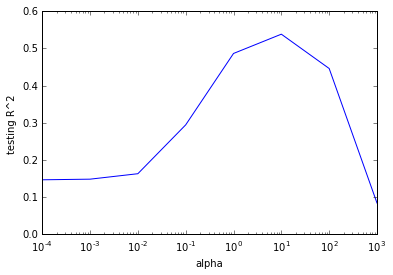

In [39]:
#Plot testing score versus alphas
plt.semilogx(alphas, test_score)
plt.xlabel('alpha')
plt.ylabel('testing R^2')

Testing score is highest at alpha = 10.  Here the lasso regression has a slightly lower training score than ordinary least squares regression.  However the testing score is higher, indicating lasso can explain about half the variance in the new, unseen data of the testing set.  This seems like fairly successful performance, given the other factors such as exercise habits that may also affect rates of cardiovascular disease.

I examine which coefficients were retained by the lasso, and their associations with cardiovascular disease, by making a bar chart of the non-zero coefficients:

In [40]:
#Get coefficient values for regression with highest testing score
optimal_index = np.argmax(test_score)
coefs2 = clf2[optimal_index].coef_
#Table of coefficients
# zip(all_food_items_array, coefs2)

<function matplotlib.pyplot.show>

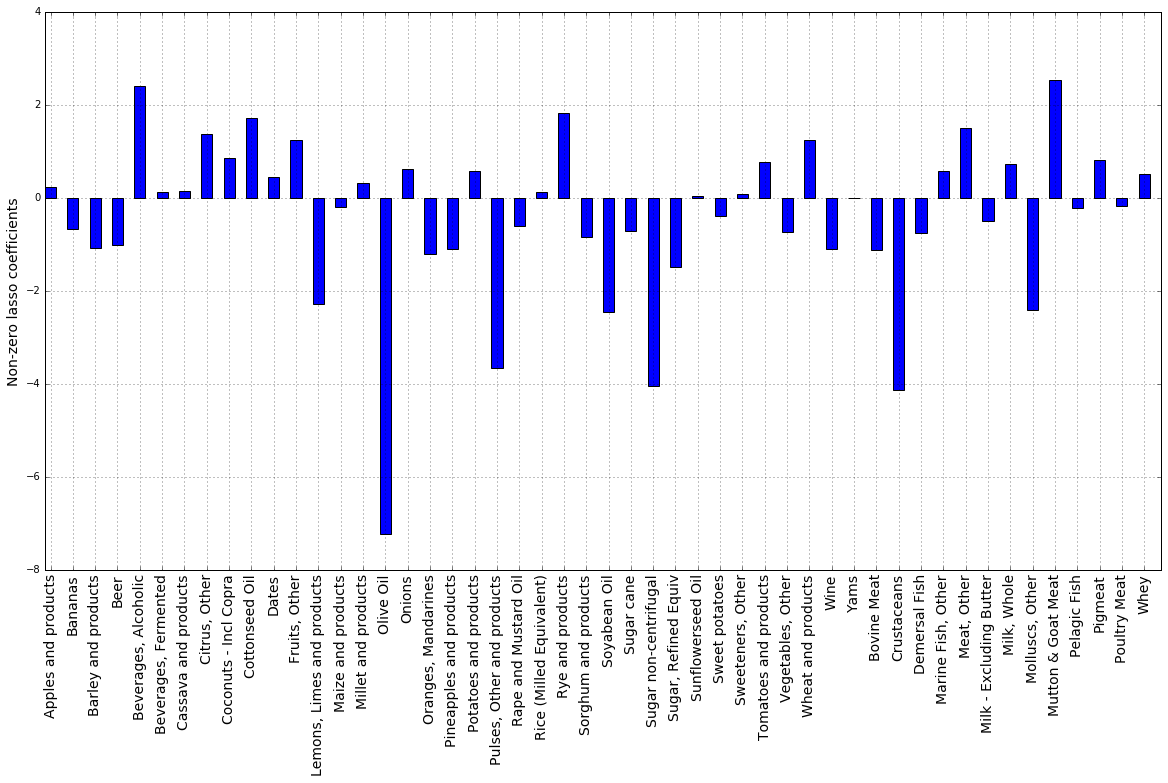

In [41]:
#Make bar chart of non zero coefficients
non_zero_coeffs2 = coefs2[np.nonzero(coefs2)]
non_zero_items = all_food_items_array[np.nonzero(coefs2)]
# print np.shape(non_zero_coeffs2)
# print np.shape(non_zero_items)
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

ind = np.arange(len(non_zero_coeffs2))  # the x locations for the groups
width = 0.5       # the width of the bars
ax.bar(ind, non_zero_coeffs2, width)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(non_zero_items)
labels = ax.get_xticklabels()
font_size = 14
plt.setp(labels, rotation=90, fontsize=font_size)
plt.ylabel('Non-zero lasso coefficients', fontsize=font_size)
ax.grid(True)
plt.show

Food items with the largest positive coefficients have positive associations with mortality from cardiovascular disease.  These include "Beverages, Alcoholic", a category that apparently includes distilled alcohol, but not wine or beer, as well as lamb and goat meats, classified as red meats.  The largest negative association by far is olive oil, a known health food.  Crustaceans, such as shrimp, crab, and lobsters, are the next most negative, although non-centrifugal sugar, described as a "traditional product" as opposed to the "industrialized alternative" of refined sugar (https://en.wikipedia.org/wiki/Non-centrifugal_cane_sugar#Nutrition_and_health), is similar.

Intuitively, it seems like global consumption patterns in these foods should match up with disease rates.  To check this, I examine the two foods with the strongest negative associations in maps:

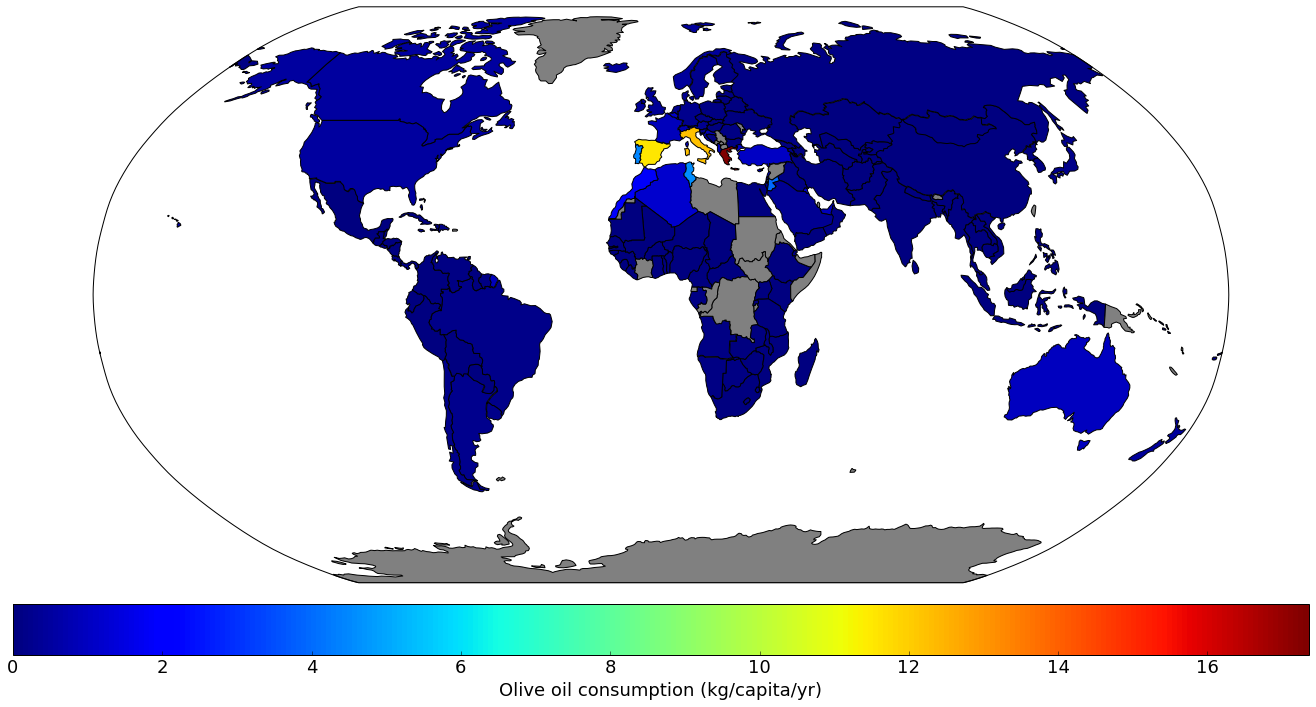

In [47]:
#Map olive oil consumption from training data
country_names = final_df_countries.tolist()
quantity_to_map = final_df_no_agg[0]['Olive Oil'].values
map_title = 'Olive oil consumption (kg/capita/yr)'
map_quantity(country_names, quantity_to_map, map_title)

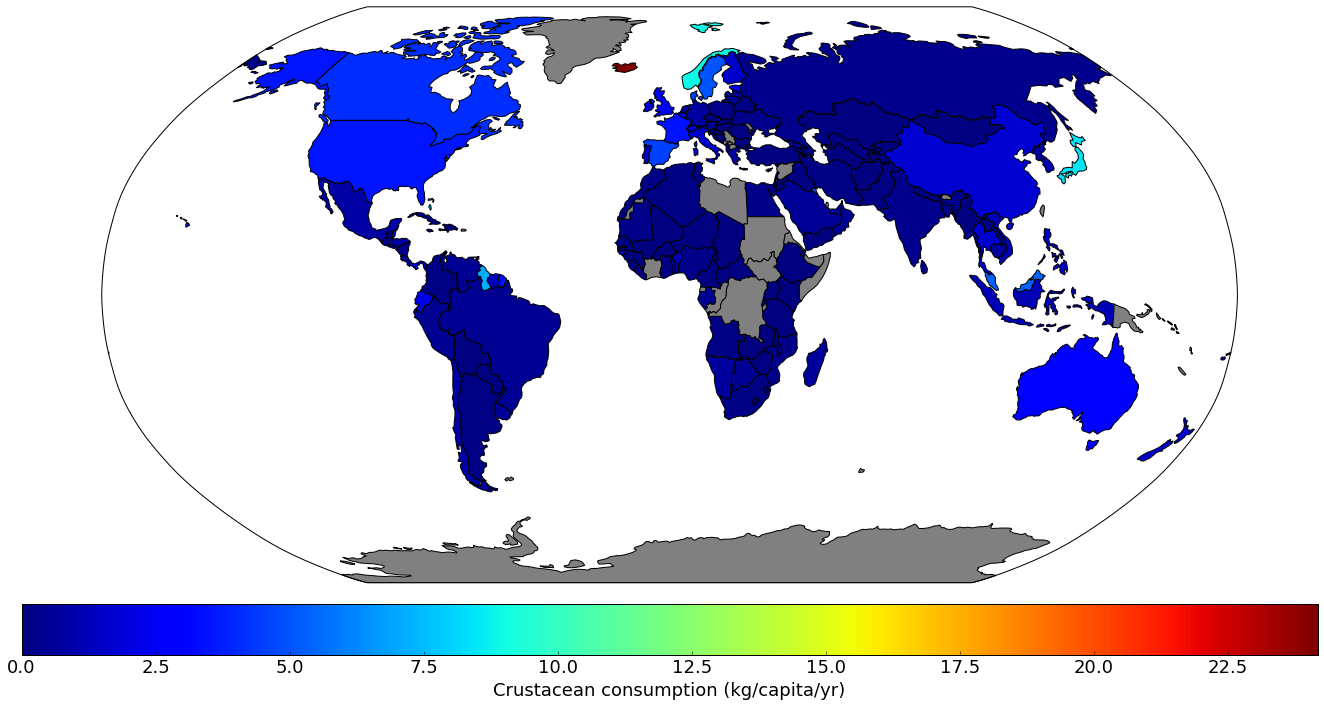

In [48]:
#Map crustacean consumption from training data
country_names = final_df_countries.tolist()
quantity_to_map = final_df_no_agg[0]['Crustaceans'].values
map_title = 'Crustacean consumption (kg/capita/yr)'
map_quantity(country_names, quantity_to_map, map_title)

Olive oil is most highly consumed in the Mediterranean region, while crustaceans are generally popular in island nations, and to some extent in the U.S., Australia and China.  Revisiting the map of cardiovascular mortality rates, it is apparent that these regions do indeed have lower rates, providing confidence in the results: 

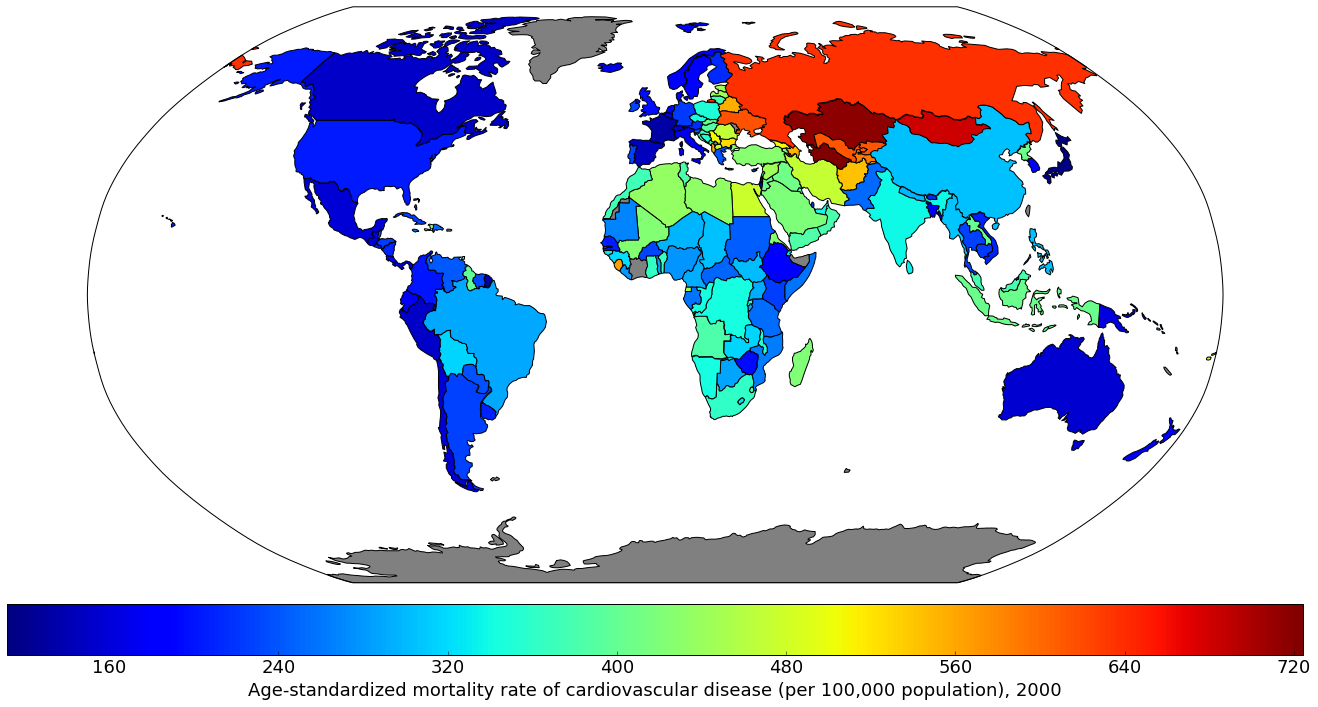

In [49]:
#Map cardiovascular mortality again
#Select 0 for 2000 results, 1 for 2012
map_index = 0

country_names = cardio_data[map_index].index.values.tolist()

quantity_to_map = cardio_data[map_index]\
['Age-standardized mortality rate by cause (per 100 000 population)'].values.astype('float')

map_title = 'Age-standardized mortality rate of cardiovascular disease (per 100,000 population), '\
+ cardio_years[map_index]
    
map_quantity(country_names, quantity_to_map, map_title)

# Conclusions

Variable selection with the lasso provided improved results over ordinary least squares regression, in terms of the testing model fit.  The lasso coefficients enabled interpretation and observation about what kinds of food are associated with cardiovascular disease mortality.



# Experimental preliminary results below

I would like to try another feature reduction technique:  principal component analysis (PCA).  PCA reduces the number of features to be used in a model by determining the axes, or principle components (PCs), of highest variation in feature-space.  PCs are linear combinations of the features, where the coefficients of each feature in a given PC are called the loadings.

Eventually, I plan to implement a regression model using the PCs.  At this point I simply calculate the PCs and then visualize them on a map, noting what the foods with the largest positive and negative loadings are for the first three PCs.

Global patterns start to emerge, with countries in distinct regional groups having either high or low scores for the first three PCs.

In [51]:
#Try mapping first few PCAs and seeing what their highest positive and negative loadings are
from sklearn.decomposition import PCA

#Apply PCA to training features
n_PCs = 3
pca = PCA(n_components=n_PCs)
pca.fit(X_train)

#Dimensionality reduction
X_train_reduced = pca.transform(X_train)

#Find out what foods have the highest 10, and lowest 10 loadings in each PC
loadings_sorted = [None]*n_PCs
high_load_foods = [None]*n_PCs
low_load_foods = [None]*n_PCs
n_high_low = 10
for i in range(n_PCs):
    #Get the components in feature space coordinates (i.e. the loadings for each food item)
    #Get the indices for sorting the foods according to their loadings
    loadings_sorted[i] = np.argsort(pca.components_[i])
#     print loadings_sorted[i]

    #Get food names with lowest and highest 10 loadings
    low_load_foods[i] = all_food_items_array[loadings_sorted[i][range(n_high_low)]]
    high_load_foods[i] = all_food_items_array[loadings_sorted[i][-n_high_low-1:-1]]
#     print high_load_foods[i]

## PCs of world diets by country

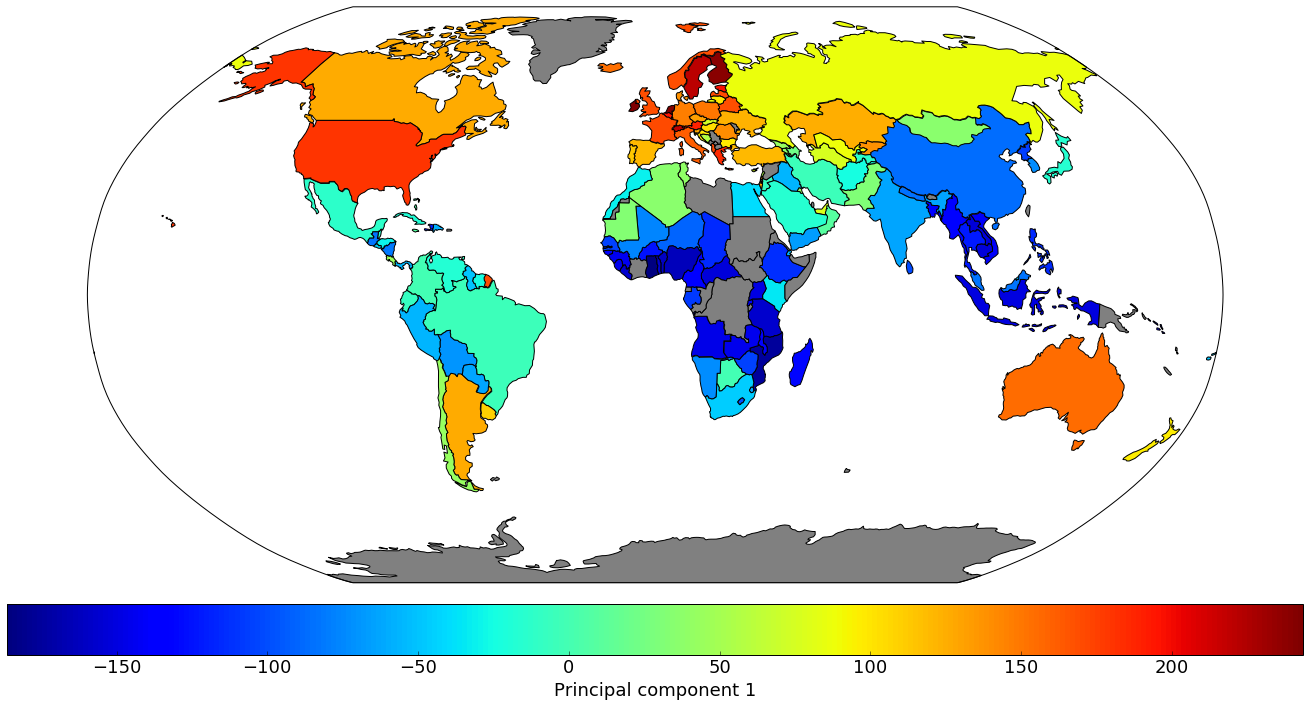

Highest loaded foods
['Oranges, Mandarines' 'Apples and products' 'Sugar, Refined Equiv'
 'Tomatoes and products' 'Pigmeat' 'Vegetables, Other' 'Beer'
 'Potatoes and products' 'Wheat and products' 'Milk, Whole']
Lowest loaded foods
['Cassava and products' 'Rice (Milled Equivalent)' 'Maize and products'
 'Plantains' 'Beverages, Fermented' 'Yams' 'Sweet potatoes' 'Roots, Other'
 'Millet and products' 'Sorghum and products']


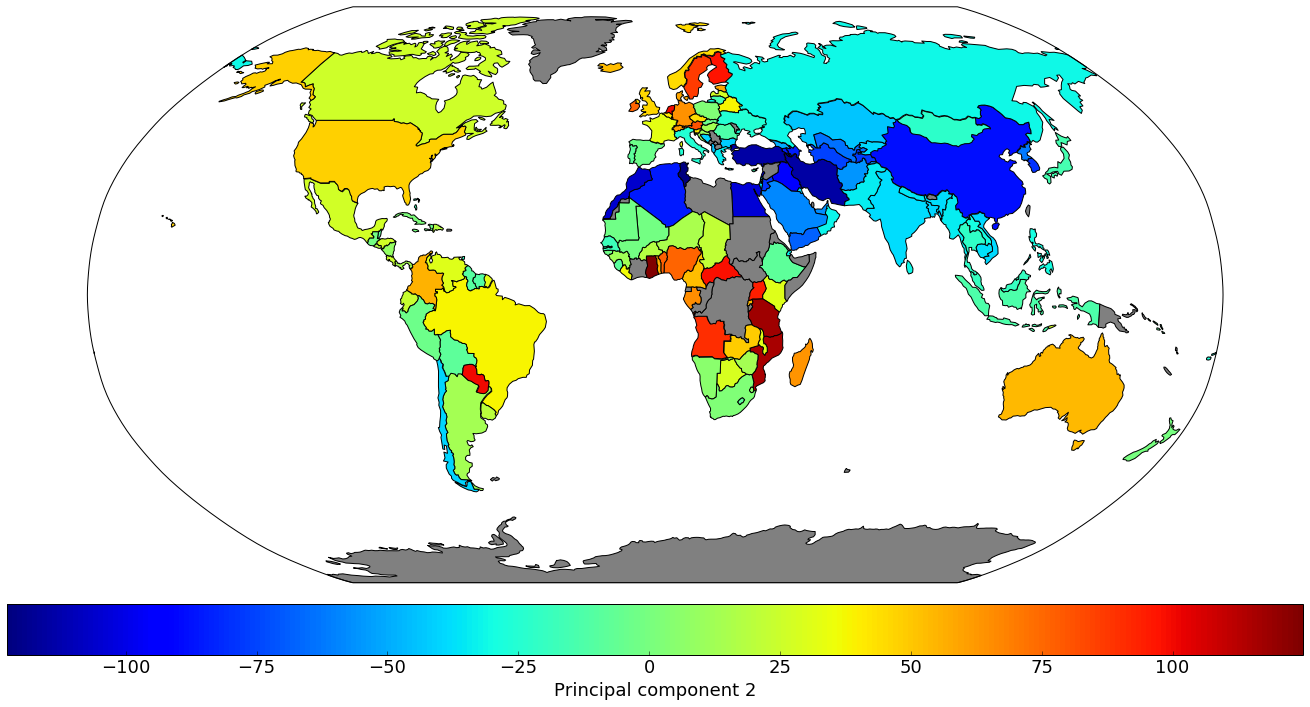

Highest loaded foods
['Potatoes and products' 'Bananas' 'Milk, Whole' 'Pigmeat'
 'Beverages, Fermented' 'Yams' 'Maize and products' 'Plantains' 'Beer'
 'Milk - Excluding Butter']
Lowest loaded foods
['Wheat and products' 'Vegetables, Other' 'Rice (Milled Equivalent)'
 'Tomatoes and products' 'Onions' 'Grapes and products (excl wine)'
 'Fruits, Other' 'Dates' 'Barley and products' 'Mutton & Goat Meat']


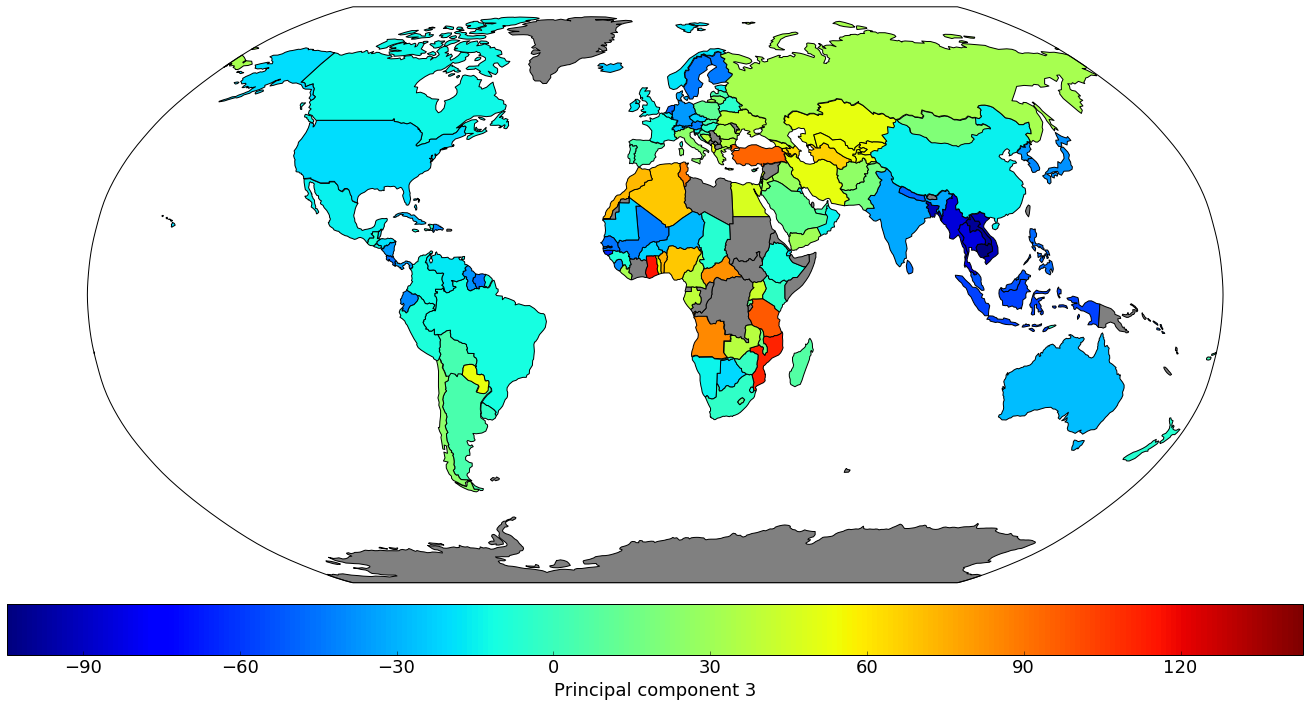

Highest loaded foods
['Beverages, Fermented' 'Grapes and products (excl wine)' 'Milk, Whole'
 'Potatoes and products' 'Plantains' 'Vegetables, Other'
 'Maize and products' 'Yams' 'Tomatoes and products' 'Wheat and products']
Lowest loaded foods
['Rice (Milled Equivalent)' 'Beer' 'Milk - Excluding Butter' 'Pigmeat'
 'Sugar, Refined Equiv' 'Coconuts - Incl Copra' 'Bananas'
 'Oranges, Mandarines' 'Poultry Meat' 'Fruits, Other']


In [52]:
#Map the PCs of the training data, 
for i in range(n_PCs):
    map_quantity(final_df_countries.tolist(),
                 X_train_reduced[:,i],
                'Principal component ' + str(i+1))

    print 'Highest loaded foods'
    print high_load_foods[i]
    print 'Lowest loaded foods'
    print low_load_foods[i]